In [85]:
""" This script is used to compute and plot the amplitudes of the CMS ECAL prototype from the ETH group at the CERN Prevessin site.
The mainly used functions to call from outside the script are down below: run_amplitude_computation.
"""

""" Imports """

import uproot
import numpy as np
import pandas as pd
import glob
import os
import h5py
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from decimal import *
from pathlib import Path


""" Global Variables """


save_folder_global = 'Synchronisation' # Processed data from time delta computation will be stored in a folder named like this. 
                                        # The data from January 2022 is in 'Synchronisation January 2022'
raw_data_folder_global = '/eos/home-s/spigazzi/Lab21/data/Reco/' # Raw data is stored here
variation_save_folder_global = 'Variation Stats ' # Variation plots are saved here
split_name = 'Merged' # Needed for legacy support, namely to be able to run the statistics_plot and variation plot functions 
                    # on the data files from January 2022 with 'Merged in their name'. Obsolete otherwise, split_name could be removed everywhere 

numbers = ['1', '2', '3', '4', '5'] # The five channels on each board
# letters = ['C']
letters = ['A', 'B', 'D', 'E'] # TODO: Add Back 'C' when board 20 (middle board) is back. It was out of order in January 2022

X = numbers.copy() # Used for colormesh plots
Y = letters.copy()
X.insert(0, '0')
Y.insert(0, '0')

# channel_names = ['C1', 'C2', 'C3', 'C4', 'C5']
channel_names = ['A1', 'A2', 'A3', 'A4', 'A5', 
                 'B1', 'B2', 'B3', 'B4', 'B5', # TODO: Add C when board C returns
                 'D1', 'D2', 'D3', 'D4', 'D5',
                 'E1', 'E2', 'E3', 'E4', 'E5']

# TODO: adapt with number of boards
""" Helper Functions """

def gaussian(x, *p):
    A, mu, sigma = p
    return A * np.exp(-(x -mu)**2/(2*sigma**2))


def to_channel_converter(channel_number):
    """ Converts the channel number to the appropriate Channel. For example 7 -> 'B3'. """
    board_counter = 0
    while channel_number > 4:
        board_counter += 1
        channel_number -= 5
    return f'{letters[board_counter]}{numbers[channel_number]}'


""" Main functions to run from outside script """

def run_amplitude_computation(run_number, save_folder = save_folder_global, raw_data_folder = raw_data_folder_global):
    """ Computes the amplitude for a run. The splits are merged into a single big run number and the time deltas are saved in an h5 file.
    
    run_number -- (string or int) the number of a run, for example '15484'
    save_folder -- (string) folder where the computed data should be stored
    raw_data_folder -- (string) folder where the raw experiment data is located
    """
    
    # Computation with merged data
    folder =  raw_data_folder + str(int(run_number))
    h = uproot.concatenate({folder+'/*.root' : 'digi'}, allow_missing = True)
    
    run_name = os.path.basename(os.path.normpath(folder))
    print('Run: ', run_name, ' Split: ', split_name)
    run_save = save_folder + '/Run ' + run_name + '/' + split_name + '/'
    Path(run_save).mkdir(parents=True, exist_ok=True)

    amp = h['amp_max'] # retrieve the amplitude
    amp_pd = pd.DataFrame(amp)
    
    # arrays to store the statistics of each channel
    mu_arr = np.zeros(len(channel_names))
    mu_error_arr = np.zeros(len(channel_names))
    sigma_arr = np.zeros(len(channel_names))
    sigma_error_arr = np.zeros(len(channel_names))
    
    for i in range(len(channel_names)):
        plt.figure()
        border_size = 2000
        #plt.xlim((250,3000))

        hist, bin_edges, _ = plt.hist(amp_pd[i], bins = 1500, label='Amplitude Histogram')
        bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)  
        
        # The fitting process
        guess = [np.max(hist), bin_centers[np.argmax(hist)], 300]
        coeff, covar = curve_fit(gaussian, bin_centers, hist, p0=guess)
        mu = coeff[1]
        mu_error = covar[1,1]
        sigma = coeff[2]
        sigma_error = covar[2,2]
        mu_arr[i] = mu
        mu_error_arr[i] = mu_error
        sigma_arr[i] = sigma
        sigma_error_arr[i] = sigma_error
        
        # plotting the histogram with a gaussian fit, the mean and the standard deviation
        plt.plot(bin_centers, gaussian(bin_centers, *coeff), label='Gaussian Fit')
        plt.axvline(mu, label = f'Mean: {np.around(mu, decimals = 1)} ps', color = 'red')
        sigma_color = 'pink'
        plt.axvline(mu + sigma, label = f'Std Dev: {np.around(sigma, decimals = 1)} ps', color = sigma_color)
        plt.axvline(mu - sigma, color = sigma_color)
        
        plt.title(f'Run: {run_name}, Channel: {channel_names[i]}')
        plt.xlabel('Amplitude (??)')
        plt.ylabel('Occurence (a.u.)')
        plt.legend(loc='best')
            
        plt.show()
        
    # saving the statistics in a file for later use, eg. in statistics_plot
    statistics = np.hstack((mu_arr.reshape(-1,1), mu_error_arr.reshape(-1,1), sigma_arr.reshape(-1,1), sigma_error_arr.reshape(-1,1)))
    print('stat', statistics)
        
    with h5py.File(run_save + 'Statistics Split ' + split_name + '.h5', 'w') as hf:
        hf.create_dataset("stats",  data=statistics)
        
        
def statistics_plot(run_number, save_folder=save_folder_global, raw_data_folder=raw_data_folder_global):
    """ Plots mu and sigma as well as their errors for the amplitude of a designated run in a colormesh plot.
    One has to have run the run_amplitude_computation function on the designated run first before using this function.
    
    run_number -- (string or int) The number of a run, for example '15484'
    save_folder -- (string) Folder where the computed data should be stored
    raw_data_folder -- (string) Folder where the raw experiment data is located
    skip_mu == (boolean) If one is not interested in mu, one can skip plotting it
    """
    
    stat_names = ['Mu', 'Mu error', 'Sigma', 'Sigma_error']
    folder =  raw_data_folder + str(int(run_number))
    run_name = os.path.basename(os.path.normpath(folder))
    print('Run: ', run_name, ' Split: ', split_name)
    run_save = save_folder + '/Run ' + str(run_name) + '/' + split_name + '/'
    Path(run_save).mkdir(parents=True, exist_ok=True)

    with h5py.File(run_save + 'Statistics Split ' + split_name + '.h5', 'r') as hf:
        statistics = hf[f"stats"][:]
    
    print(statistics)
    for i in range(len(statistics[0,:])):
        plt.figure()
        stat_data = statistics[:,i].reshape(len(letters), len(numbers))
        c = plt.pcolormesh(X, Y, stat_data)
        cb = plt.colorbar(c)
        cb.set_label('Max amplitude over Channels (??)')
        plt.title(f'{stat_names[i]}, Run: {run_name}, Split: {split_name}')
        plt.show()
        
    plt.savefig(run_save + f'Stats Colormesh.pdf', dpi = 300)
            
""" Example uses """       
def example(number):
    if number==1:
        run_amplitude_computation(15503) # January
        # run_amplitude_computation(15610) # June
    if number==2:
        statistics_plot(15500)
        statistics_plot(15503)
        
""" January 2022 Data 
One can input these into the variation_plot function, or any of the runs into the run_amplitude_computation function.
"""
# included_runs = [15358, 15359, 15362, 15366] # Power cycle 1
# included_runs = [15384, 15387, 15389, 15390, 15395, 15397, 15400, 15401] Power cycle 2
# included_runs = [15483, 15484, 15487, 15489, 15490, 15491, 15492, 15493, 15500, 15503, 15511, 15513, 15516, 15524, 15525, 15527, 15533, 15541] # Temperature 07.02.2022
# included_runs = [15373, 15387, 15422, 15533] # Variation over several days


' January 2022 Data \nOne can input these into the variation_plot function, or any of the runs into the run_amplitude_computation function.\n'

Run:  15503  Split:  Merged


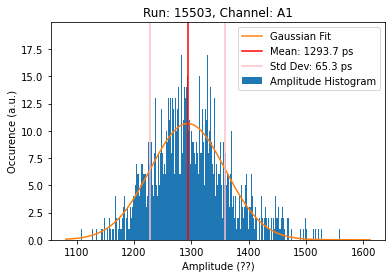

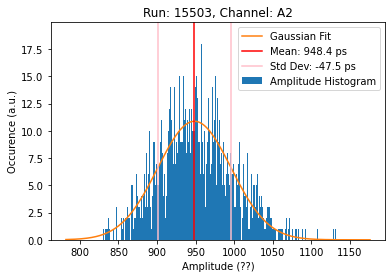

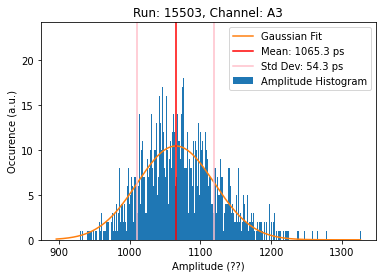

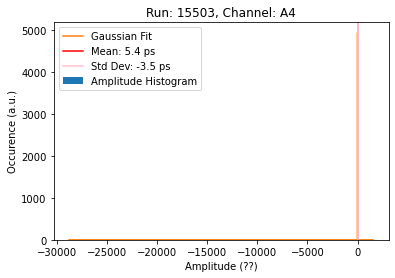

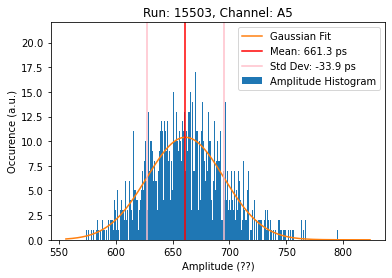

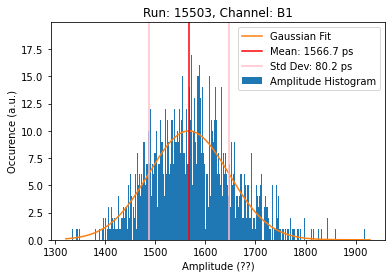

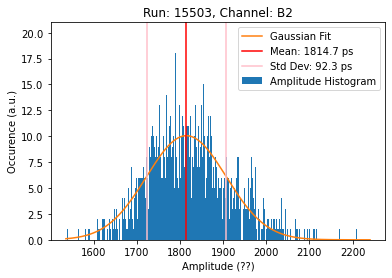

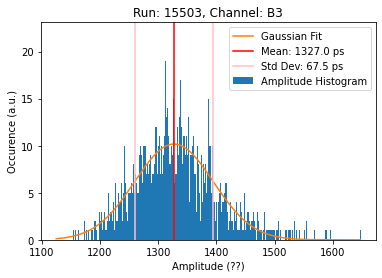

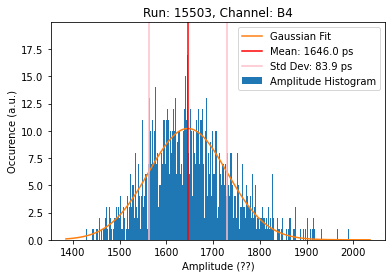

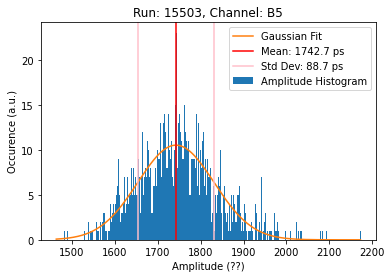

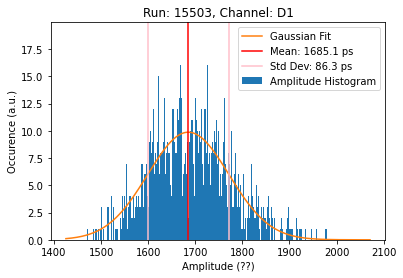

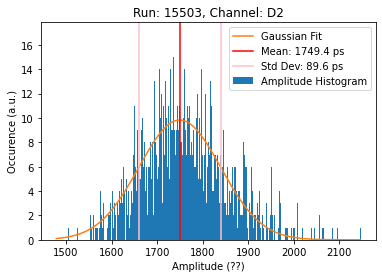

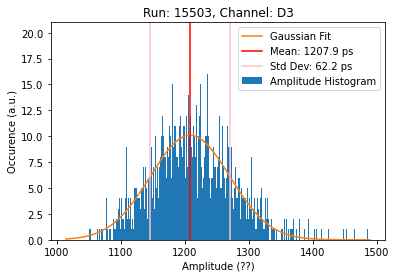

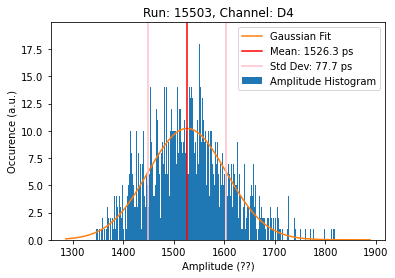

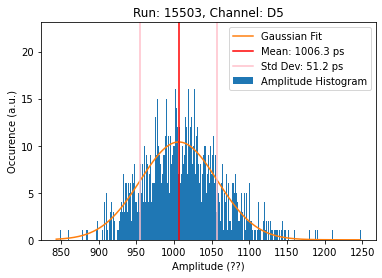

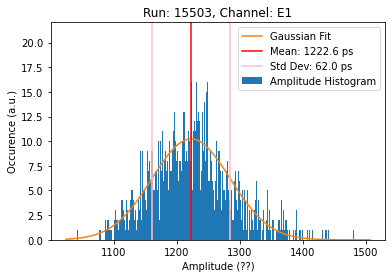

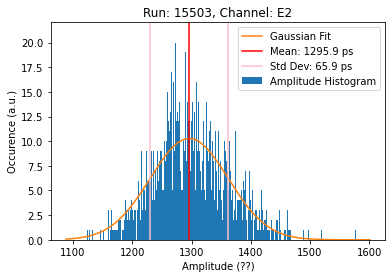

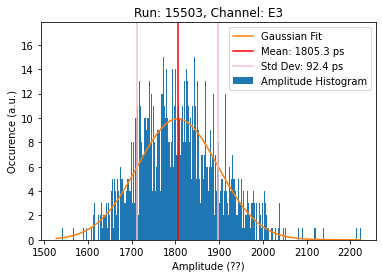

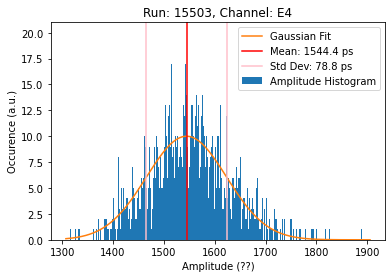

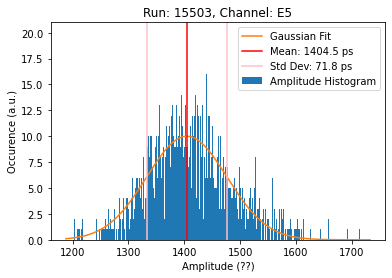

stat [[ 1.29367579e+03  7.26965949e-01  6.52823955e+01  7.27302935e-01]
 [ 9.48385494e+02  3.98380588e-01 -4.75176843e+01  3.98422957e-01]
 [ 1.06527063e+03  5.91296675e-01  5.43366364e+01  5.91890936e-01]
 [ 5.39292551e+00  1.62408978e+05 -3.47379311e+00  5.11654958e+03]
 [ 6.61255918e+02  2.31739955e-01 -3.38839308e+01  2.31985281e-01]
 [ 1.56674294e+03  1.20598553e+00  8.02403763e+01  1.20754801e+00]
 [ 1.81466411e+03  1.61285572e+00  9.23001598e+01  1.61536739e+00]
 [ 1.32703591e+03  8.20650682e-01  6.75425072e+01  8.22157534e-01]
 [ 1.64603144e+03  1.34931923e+00  8.38846010e+01  1.35068830e+00]
 [ 1.74266432e+03  1.51457773e+00  8.86935164e+01  1.51587486e+00]
 [ 1.68511109e+03  1.48767670e+00  8.63366983e+01  1.49014082e+00]
 [ 1.74935847e+03  1.57337567e+00  8.95732034e+01  1.57581929e+00]
 [ 1.20791820e+03  7.11516302e-01  6.21874835e+01  7.12194810e-01]
 [ 1.52631808e+03  1.06735109e+00  7.76657373e+01  1.06852393e+00]
 [ 1.00625015e+03  5.44468734e-01  5.12299930e+01  5.4485

In [86]:
example(1)

Run:  15500  Split:  Merged
[[ 1.29265667e+03  1.51715669e+00  6.55036754e+01  1.52054853e+00]
 [ 9.48394760e+02  8.06288627e-01 -4.78083634e+01  8.07726383e-01]
 [ 1.06259478e+03  8.43723271e-01  5.25508407e+01  8.43821180e-01]
 [ 1.38741114e+03  1.71980957e+00  6.99541172e+01  1.72111456e+00]
 [ 6.60665263e+02  3.76825483e-01  3.32586325e+01  3.77688414e-01]
 [ 1.56145553e+03  1.97913885e+00  8.01233263e+01  1.97948998e+00]
 [ 1.80613356e+03  2.34942006e+00  8.76273570e+01  2.35094576e+00]
 [ 1.32420296e+03  1.39574776e+00  6.50820745e+01  1.39703349e+00]
 [ 1.63800212e+03  2.02016205e+00  7.98508492e+01  2.02097891e+00]
 [ 1.73350897e+03  2.46298432e+00  8.66854820e+01  2.46676883e+00]
 [ 1.68125058e+03  2.13255695e+00  8.31159215e+01  2.13549006e+00]
 [ 1.74415837e+03  3.34178116e-01  8.52970159e+01  3.34178115e-01]
 [ 1.20452705e+03  1.18887302e+00  6.04774149e+01  1.19004536e+00]
 [ 1.51962356e+03  1.68254985e+00  7.43307404e+01  1.68382803e+00]
 [ 1.00286034e+03  7.99419587e-01 

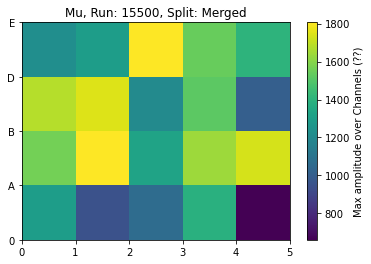

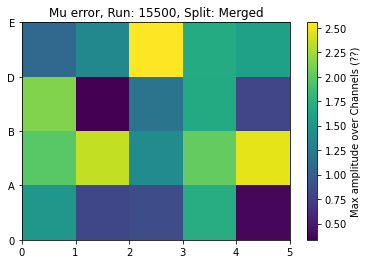

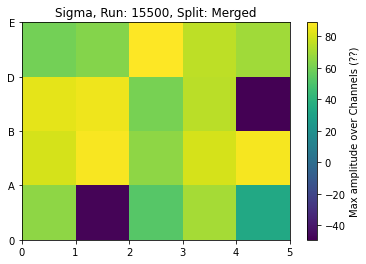

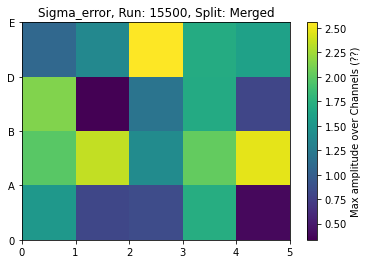

Run:  15503  Split:  Merged
[[ 1.29367579e+03  7.26965949e-01  6.52823955e+01  7.27302935e-01]
 [ 9.48385494e+02  3.98380588e-01 -4.75176843e+01  3.98422957e-01]
 [ 1.06527063e+03  5.91296675e-01  5.43366364e+01  5.91890936e-01]
 [ 5.39292551e+00  1.62408978e+05 -3.47379311e+00  5.11654958e+03]
 [ 6.61255918e+02  2.31739955e-01 -3.38839308e+01  2.31985281e-01]
 [ 1.56674294e+03  1.20598553e+00  8.02403763e+01  1.20754801e+00]
 [ 1.81466411e+03  1.61285572e+00  9.23001598e+01  1.61536739e+00]
 [ 1.32703591e+03  8.20650682e-01  6.75425072e+01  8.22157534e-01]
 [ 1.64603144e+03  1.34931923e+00  8.38846010e+01  1.35068830e+00]
 [ 1.74266432e+03  1.51457773e+00  8.86935164e+01  1.51587486e+00]
 [ 1.68511109e+03  1.48767670e+00  8.63366983e+01  1.49014082e+00]
 [ 1.74935847e+03  1.57337567e+00  8.95732034e+01  1.57581929e+00]
 [ 1.20791820e+03  7.11516302e-01  6.21874835e+01  7.12194810e-01]
 [ 1.52631808e+03  1.06735109e+00  7.76657373e+01  1.06852393e+00]
 [ 1.00625015e+03  5.44468734e-01 

<Figure size 432x288 with 0 Axes>

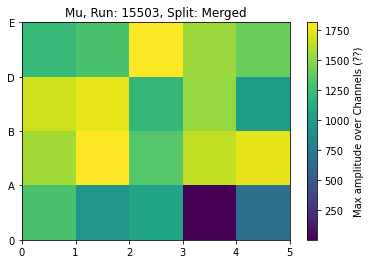

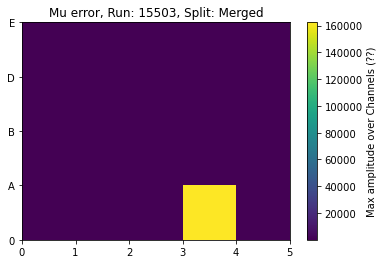

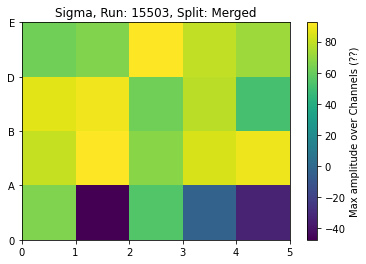

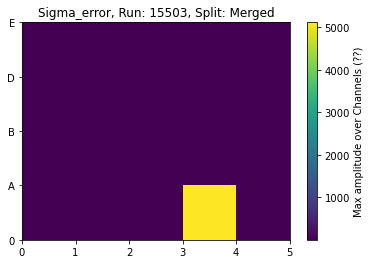

<Figure size 432x288 with 0 Axes>

In [87]:
example(2)